## PREPROCESSING

### Preprocessing SMOTE + DA

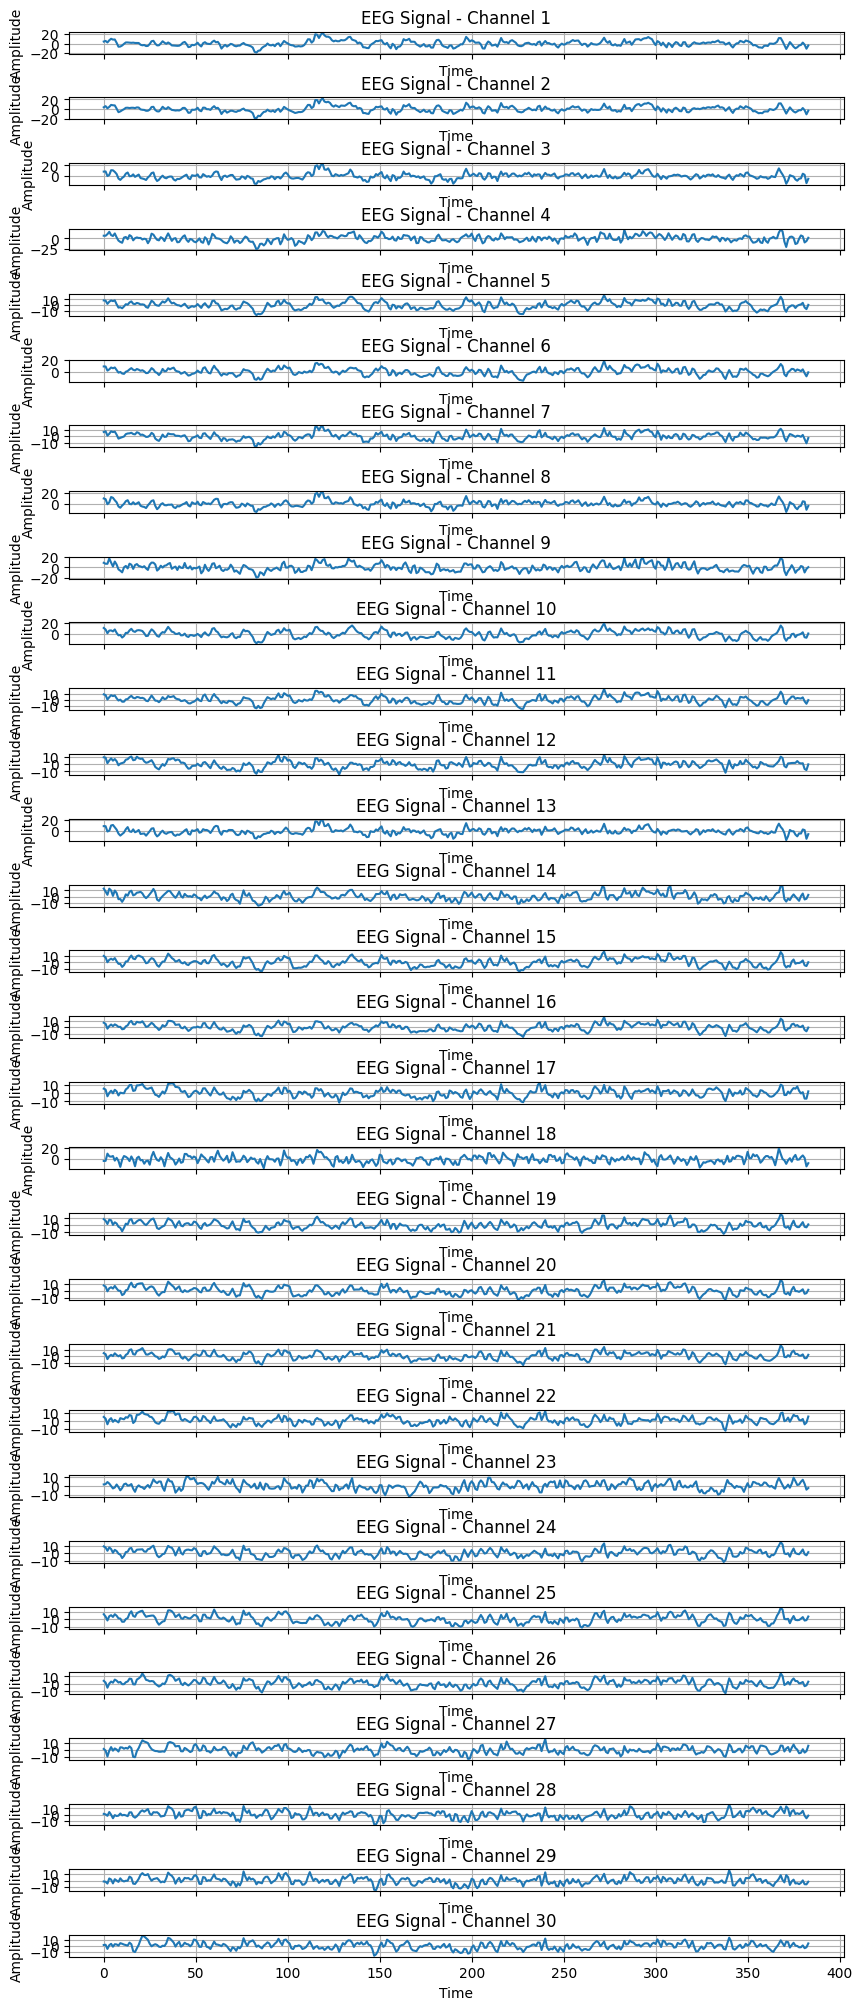

In [12]:
import scipy.io
import matplotlib.pyplot as plt

# Load the .mat file
data = scipy.io.loadmat('unbalanced_dataset.mat')

# Access the variables from the loaded data
eeg_data = data['EEGsample']
subject_indexes = data['subindex']
labels = data['substate']

# Select a sample to visualize
sample_index = 0
sample = eeg_data[sample_index]

# Configure the subplot layout
num_channels = sample.shape[0]
fig, axs = plt.subplots(num_channels, 1, figsize=(10, 25), sharex=True)

# Plot the EEG signals for each channel
for channel in range(num_channels):
    axs[channel].plot(sample[channel])
    axs[channel].set_ylabel('Amplitude')
    axs[channel].set_xlabel('Time')
    axs[channel].set_title('EEG Signal - Channel {}'.format(channel+1))
    axs[channel].grid(True)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=2.0)

plt.show()


In [4]:
import numpy as np
import scipy.io
from scipy import signal
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.preprocessing.image import ImageDataGenerator

def preprocess_EEG_data():
    # Load the data from the .mat file
    data = scipy.io.loadmat('unbalanced_dataset.mat')
    eeg_data = data['EEGsample']
    subject_indexes = data['subindex']
    labels = data['substate']

    # Define filter parameters
    filter_order = 4
    alpha_band = [8, 12]
    beta_band = [12, 30]
    delta_band = [1, 4]
    theta_band = [4, 8]

    # Define window size and overlap
    window_size = 3  # 3 seconds
    overlap = 0.5  # 50% overlap

    # Define sampling frequency and calculate number of samples in a window
    sampling_frequency = 128
    samples_per_window = int(window_size * sampling_frequency)

    # Calculate num_windows, num_channels, and num_total_samples
    num_samples, num_channels, num_total_samples = eeg_data.shape
    num_windows = int(np.ceil(num_total_samples / samples_per_window))

    # Initialize the filtered sample matrix
    filtered_sample = np.zeros((num_samples, num_windows, 4 * num_channels, samples_per_window))

    # Apply the filter to each channel and concatenate the frequency bands
    for i in range(num_samples):
        for j in range(num_windows):
            start_index = int(j * samples_per_window * (1 - overlap))
            end_index = min(int(start_index + samples_per_window), num_total_samples)
            channel_data = eeg_data[i, :, start_index:end_index]
            alpha_filter = signal.butter(filter_order, alpha_band, btype='bandpass', fs=sampling_frequency,
                                         output='sos')
            beta_filter = signal.butter(filter_order, beta_band, btype='bandpass', fs=sampling_frequency,
                                        output='sos')
            delta_filter = signal.butter(filter_order, delta_band, btype='bandpass', fs=sampling_frequency,
                                         output='sos')
            theta_filter = signal.butter(filter_order, theta_band, btype='bandpass', fs=sampling_frequency,
                                         output='sos')
            alpha_power = signal.sosfilt(alpha_filter, channel_data)
            beta_power = signal.sosfilt(beta_filter, channel_data)
            delta_power = signal.sosfilt(delta_filter, channel_data)
            theta_power = signal.sosfilt(theta_filter, channel_data)
            filtered_sample[i, j, :, :] = np.concatenate((alpha_power, beta_power, delta_power, theta_power), axis=0)

    # Reshape the filtered sample matrix for input to the CNN
    filtered_sample = filtered_sample.transpose((0, 2, 3, 1))  # Transpose to (num_samples, num_windows, samples_per_window, 4 * num_channels)

    # Normalize the data
    mean = np.mean(filtered_sample)
    std = np.std(filtered_sample)
    filtered_sample = (filtered_sample - mean) / std

    # Split the data into training and testing sets
    train_indices = np.where(subject_indexes < 9)[0]
    test_indices = np.where(subject_indexes >= 9)[0]
    train_data = filtered_sample[train_indices]
    train_labels = labels[train_indices]
    test_data = filtered_sample[test_indices]
    test_labels = labels[test_indices]

    # Apply data augmentation to the training data
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode="nearest"
    )
    augmented_data = []
    augmented_labels = []

    for sample, label in zip(train_data, train_labels):
        augmented_samples = datagen.flow(np.expand_dims(sample, axis=0), batch_size=1)
        augmented_data.append(augmented_samples[0][0])
        augmented_labels.append(label)

    # Convert the augmented data to a numpy array
    augmented_data = np.array(augmented_data)

    # Convert augmented labels to a numpy array
    augmented_labels = np.array(augmented_labels)

    # Concatenate the augmented data with the original training data
    train_data = np.concatenate((train_data, augmented_data), axis=0)
    train_labels = np.concatenate((train_labels, augmented_labels), axis=0)

    # Reshape the data for SMOTE
    train_data_smote = train_data.reshape((-1, num_windows * samples_per_window * 4 * num_channels))

    # Apply SMOTE to balance the data
    smote = SMOTE()
    train_data_balanced, train_labels_balanced = smote.fit_resample(train_data_smote, train_labels)

    # Reshape the balanced data back to the original format
    train_data_balanced = train_data_balanced.reshape((-1, num_windows, samples_per_window, 4 * num_channels))

    # Print the class distribution of the balanced data
    unique, counts = np.unique(train_labels_balanced, return_counts=True)
    print("Class Distribution (Balanced Train Data):", dict(zip(unique, counts)))

    # Print the class distribution of the test data
    unique_test, counts_test = np.unique(test_labels, return_counts=True)
    print("Class Distribution (Test Data):", dict(zip(unique_test, counts_test)))

    # Save the preprocessed data as numpy arrays
    np.save('preprocessedData_SMOTE_DA/train_data.npy', train_data_balanced)
    np.save('preprocessedData_SMOTE_DA/train_labels.npy', train_labels_balanced)
    np.save('preprocessedData_SMOTE_DA/test_data.npy', test_data)
    np.save('preprocessedData_SMOTE_DA/test_labels.npy', test_labels)

    return train_data_balanced, train_labels_balanced, test_data, test_labels

train_data, train_labels, test_data, test_labels = preprocess_EEG_data()

Class Distribution (Balanced Train Data): {0: 2366, 1: 2366}
Class Distribution (Test Data): {0: 548, 1: 342}


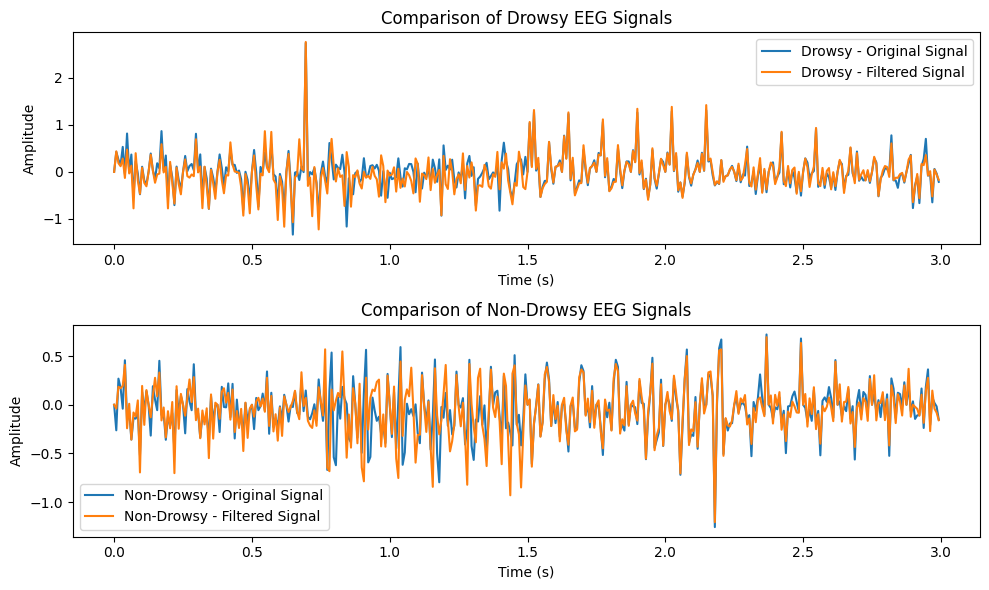

In [5]:
import matplotlib.pyplot as plt

# Select example indices for drowsy and non-drowsy signals
drowsy_example_index = 0
non_drowsy_example_index = 1

# Get the original and filtered signals for the selected drowsy example
drowsy_original_signal = train_data[train_labels == 1][drowsy_example_index, 0, :, 0]
drowsy_filtered_signal = train_data[train_labels == 1][drowsy_example_index, 0, :, 1]

# Get the original and filtered signals for the selected non-drowsy example
non_drowsy_original_signal = train_data[train_labels == 0][non_drowsy_example_index, 0, :, 0]
non_drowsy_filtered_signal = train_data[train_labels == 0][non_drowsy_example_index, 0, :, 1]

# Create a time axis based on the sampling frequency
sampling_frequency = 128
time = np.arange(len(drowsy_original_signal)) / sampling_frequency

# Plot the drowsy and non-drowsy signals
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(time, drowsy_original_signal, label='Drowsy - Original Signal')
plt.plot(time, drowsy_filtered_signal, label='Drowsy - Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Comparison of Drowsy EEG Signals')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, non_drowsy_original_signal, label='Non-Drowsy - Original Signal')
plt.plot(time, non_drowsy_filtered_signal, label='Non-Drowsy - Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Comparison of Non-Drowsy EEG Signals')
plt.legend()

plt.tight_layout()
plt.show()


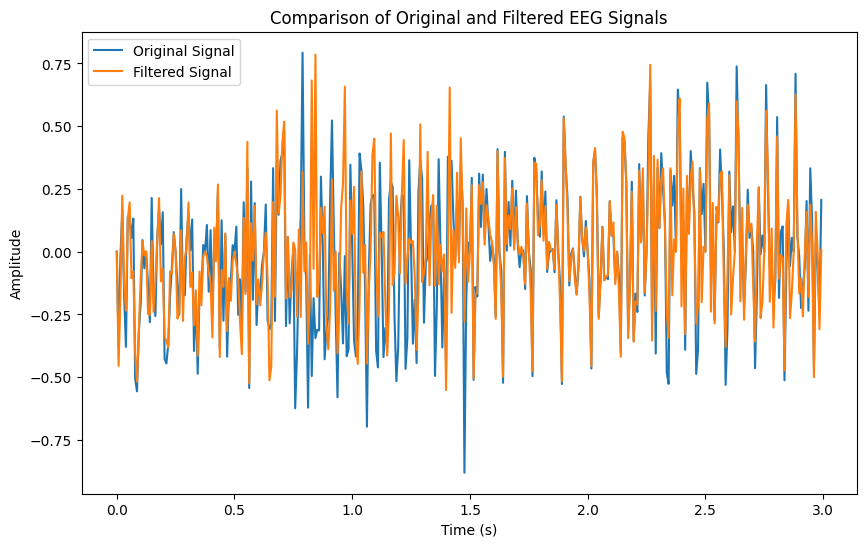

In [112]:
import matplotlib.pyplot as plt

# Select an example EEG signal to compare
example_index = 0

# Get the original and filtered signals for the selected example
original_signal = train_data[example_index, 0, :, 0]
filtered_signal = train_data[example_index, 0, :, 1]

# Create a time axis based on the sampling frequency
sampling_frequency = 128
time = np.arange(len(original_signal)) / sampling_frequency

# Plot the original and filtered signals
plt.figure(figsize=(10, 6))
plt.plot(time, original_signal, label='Original Signal')
plt.plot(time, filtered_signal, label='Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Comparison of Original and Filtered EEG Signals')
plt.legend()
plt.show()


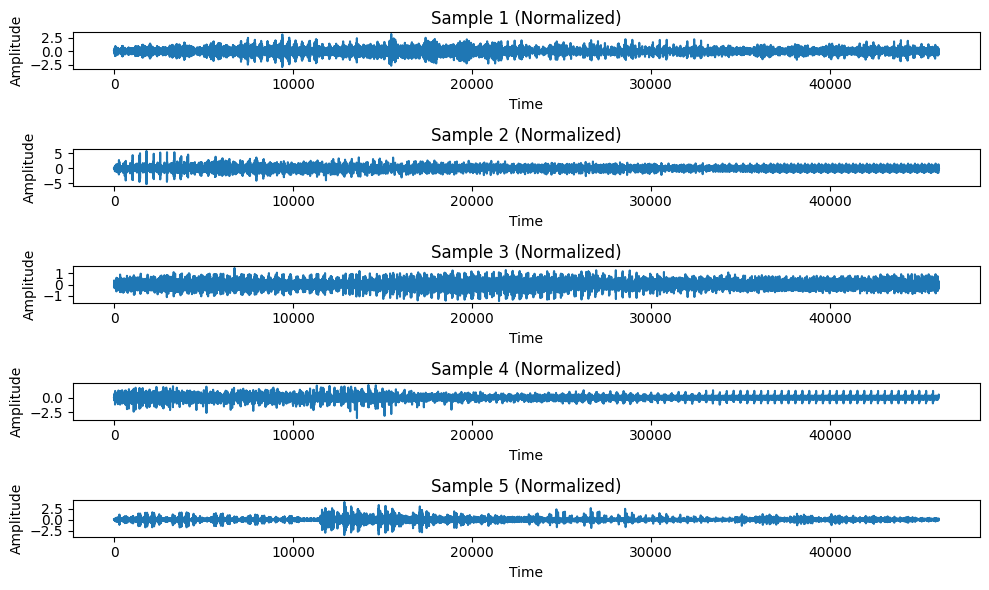

In [119]:
import matplotlib.pyplot as plt

# Select a few sample EEG signals
num_samples = 5
sample_indices = np.random.choice(len(train_data), size=num_samples, replace=False)
sample_signals = train_data[sample_indices]

# Plot the normalized EEG signals
fig, ax = plt.subplots(num_samples, 1, figsize=(10, 6))
for i, signal in enumerate(sample_signals):
    signal_reshaped = signal.reshape(-1)
    ax[i].plot(signal_reshaped)
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Amplitude')
    ax[i].set_title(f'Sample {i+1} (Normalized)')
plt.tight_layout()
plt.show()


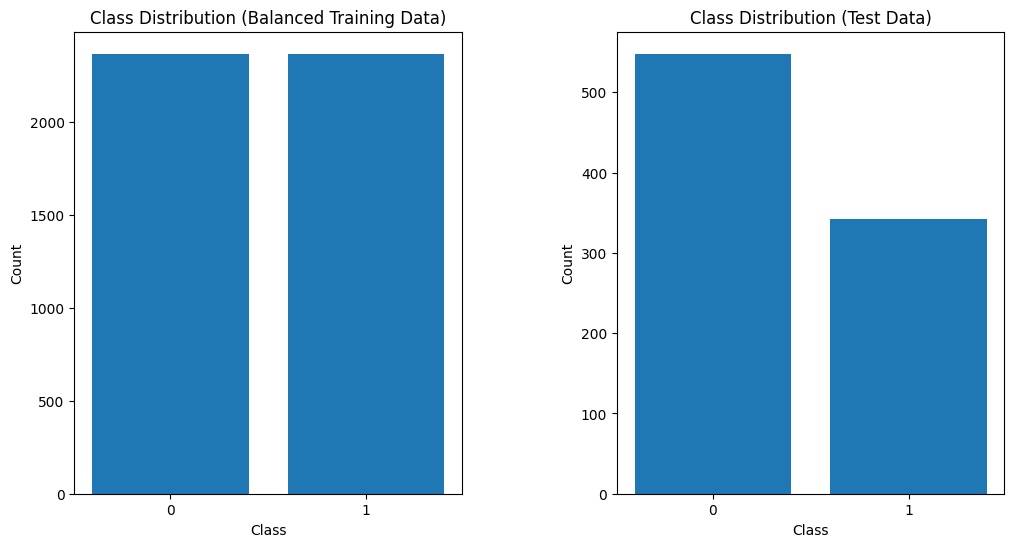

In [122]:
import matplotlib.pyplot as plt

# Calculate the class distribution of the balanced training data
unique_train, counts_train = np.unique(train_labels, return_counts=True)

# Calculate the class distribution of the test data
unique_test, counts_test = np.unique(test_labels, return_counts=True)

# Plot the bar charts side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the bar chart for the balanced training data
ax1.bar(unique_train, counts_train)
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_title('Class Distribution (Balanced Training Data)')
ax1.set_xticks(unique_train)

# Plot the bar chart for the test data
ax2.bar(unique_test, counts_test)
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.set_title('Class Distribution (Test Data)')
ax2.set_xticks(unique_test)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Display the plot
plt.show()


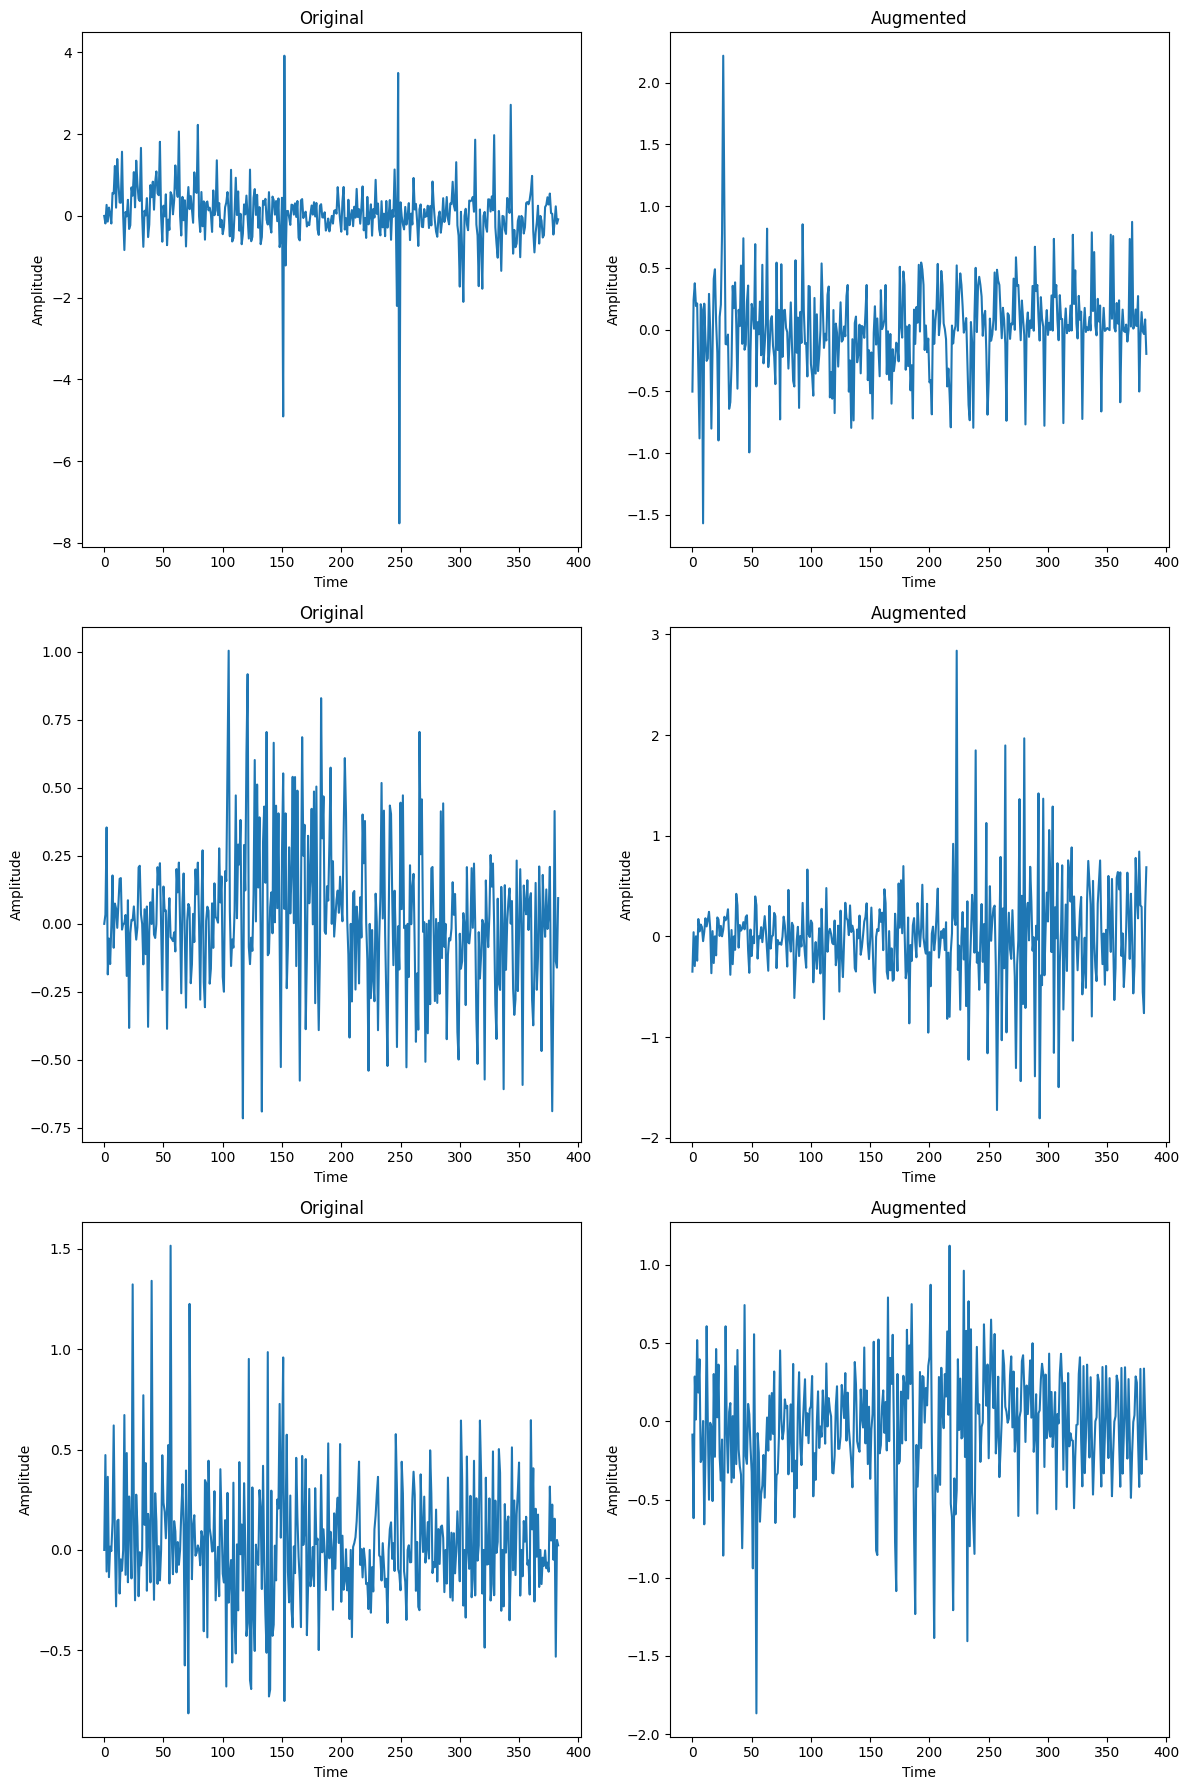

In [124]:
import matplotlib.pyplot as plt

# Select a few samples from the augmented training data
num_samples = 3
sample_indices = np.random.choice(len(train_data) // 2, num_samples, replace=False)

# Plot the original sample and its augmented versions side-by-side
fig, ax = plt.subplots(num_samples, 2, figsize=(12, 6*num_samples))

for i, index in enumerate(sample_indices):
    # Plot the original sample
    ax[i, 0].plot(train_data[index, :, :, 0].flatten())
    ax[i, 0].set_title('Original')
    ax[i, 0].set_xlabel('Time')
    ax[i, 0].set_ylabel('Amplitude')

    # Plot the augmented sample
    ax[i, 1].plot(train_data[index + len(train_data) // 2, :, :, 0].flatten())
    ax[i, 1].set_title('Augmented')
    ax[i, 1].set_xlabel('Time')
    ax[i, 1].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()


### Preprocessing SMOTE

In [1]:
import numpy as np
import scipy.io
from scipy import signal
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

def preprocess_EEG_data():
    # Load the data from the .mat file
    data = scipy.io.loadmat('unbalanced_dataset.mat')
    eeg_data = data['EEGsample']
    subject_indexes = data['subindex']
    labels = data['substate']

    # Define filter parameters
    filter_order = 4
    alpha_band = [8, 12]
    beta_band = [12, 30]
    delta_band = [1, 4]
    theta_band = [4, 8]

    # Define window size and overlap
    window_size = 3  # 3 seconds
    overlap = 0.5  # 50% overlap

    # Define sampling frequency and calculate number of samples in a window
    sampling_frequency = 128
    samples_per_window = int(window_size * sampling_frequency)

    # Calculate num_windows, num_channels, and num_total_samples
    num_samples, num_channels, num_total_samples = eeg_data.shape
    num_windows = int(np.ceil(num_total_samples / samples_per_window))

    # Initialize the filtered sample matrix
    filtered_sample = np.zeros((num_samples, num_windows, 4 * num_channels, samples_per_window))

    # Apply the filter to each channel and concatenate the frequency bands
    for i in range(num_samples):
        for j in range(num_windows):
            start_index = int(j * samples_per_window * (1 - overlap))
            end_index = min(int(start_index + samples_per_window), num_total_samples)
            channel_data = eeg_data[i, :, start_index:end_index]
            alpha_filter = signal.butter(filter_order, alpha_band, btype='bandpass', fs=sampling_frequency,
                                         output='sos')
            beta_filter = signal.butter(filter_order, beta_band, btype='bandpass', fs=sampling_frequency,
                                        output='sos')
            delta_filter = signal.butter(filter_order, delta_band, btype='bandpass', fs=sampling_frequency,
                                         output='sos')
            theta_filter = signal.butter(filter_order, theta_band, btype='bandpass', fs=sampling_frequency,
                                         output='sos')
            alpha_power = signal.sosfilt(alpha_filter, channel_data)
            beta_power = signal.sosfilt(beta_filter, channel_data)
            delta_power = signal.sosfilt(delta_filter, channel_data)
            theta_power = signal.sosfilt(theta_filter, channel_data)
            filtered_sample[i, j, :, :] = np.concatenate((alpha_power, beta_power, delta_power, theta_power), axis=0)

    # Reshape the filtered sample matrix for input to the CNN
    filtered_sample = filtered_sample.transpose((0, 2, 3, 1))  # Transpose to (num_samples, num_windows, samples_per_window, 4 * num_channels)

    # Normalize the data
    mean = np.mean(filtered_sample)
    std = np.std(filtered_sample)
    filtered_sample = (filtered_sample - mean) / std

    # Split the data into training and testing sets
    train_indices = np.where(subject_indexes < 9)[0]
    test_indices = np.where(subject_indexes >= 9)[0]
    train_data = filtered_sample[train_indices]
    train_labels = labels[train_indices]
    test_data = filtered_sample[test_indices]
    test_labels = labels[test_indices]

    # Print the class distribution of the balanced data
    unique, counts = np.unique(train_labels, return_counts=True)
    print("Class Distribution (Raw Train Data):", dict(zip(unique, counts)))

    # Print the class distribution of the test data
    unique_test, counts_test = np.unique(test_labels, return_counts=True)
    print("Class Distribution (Raw Test Data):", dict(zip(unique_test, counts_test)))

    # Reshape the data for SMOTE
    train_data_smote = train_data.reshape((-1, num_windows * samples_per_window * 4 * num_channels))

    # Apply SMOTE to balance the data
    smote = SMOTE()
    train_data_balanced, train_labels_balanced = smote.fit_resample(train_data_smote, train_labels)

    # Reshape the balanced data back to the original format
    train_data_balanced = train_data_balanced.reshape((-1, num_windows, samples_per_window, 4 * num_channels))

    # Print the class distribution of the balanced data
    unique, counts = np.unique(train_labels_balanced, return_counts=True)
    print("Class Distribution (Balanced Train Data):", dict(zip(unique, counts)))

    # Print the class distribution of the test data
    unique_test, counts_test = np.unique(test_labels, return_counts=True)
    print("Class Distribution (Test Data):", dict(zip(unique_test, counts_test)))

    print("num_windows:", num_windows)
    print("samples_per_window:", samples_per_window)
    print("num_channels:", num_channels)

    print("filtered_sample shape:", filtered_sample.shape)

    # Save the preprocessed data as numpy arrays
    np.save('preprocessedData_SMOTE/train_data.npy', train_data_balanced)
    np.save('preprocessedData_SMOTE/train_labels.npy', train_labels_balanced)
    np.save('preprocessedData_SMOTE/test_data.npy', test_data)
    np.save('preprocessedData_SMOTE/test_labels.npy', test_labels)

    return train_data_balanced, train_labels_balanced, test_data, test_labels


train_data, train_labels, test_data, test_labels = preprocess_EEG_data()


Class Distribution (Raw Train Data): {0: 1183, 1: 879}
Class Distribution (Raw Test Data): {0: 548, 1: 342}
Class Distribution (Balanced Train Data): {0: 1183, 1: 1183}
Class Distribution (Test Data): {0: 548, 1: 342}
num_windows: 1
samples_per_window: 384
num_channels: 30
filtered_sample shape: (2952, 120, 384, 1)


# CNN MODEL, TRAINING, & EVALUATING

### CNN Model SMOTE Only

In [46]:
import numpy as np
import tensorflow as keras
from keras import layers
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping

# Define input shape for CNN model
height = 1
width = 384
channels = 4 * 30

# Load preprocessed data from .npy files
x_train = np.load('preprocessedData_SMOTE/train_data.npy')
x_test = np.load('preprocessedData_SMOTE/test_data.npy')
y_train = np.load('preprocessedData_SMOTE/train_labels.npy')
y_test = np.load('preprocessedData_SMOTE/test_labels.npy')

# Reshape data into appropriate tensor format for CNN model
x_train = x_train.reshape((-1, channels, width, height))
x_test = x_test.reshape((-1, channels, width, height))

# Define the CNN model
model = keras.Sequential(
    [
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(120, 384, 1)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

# Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred, zero_division=1))

Epoch 1/10
37/37 [==============================] - 19s 493ms/step - loss: 1.2938 - accuracy: 0.4987 - val_loss: 0.6880 - val_accuracy: 0.6382
Epoch 2/10
37/37 [==============================] - 15s 402ms/step - loss: 0.6845 - accuracy: 0.6243 - val_loss: 0.6728 - val_accuracy: 0.6888
Epoch 3/10
37/37 [==============================] - 14s 381ms/step - loss: 0.6584 - accuracy: 0.6788 - val_loss: 0.6537 - val_accuracy: 0.6416
Epoch 4/10
37/37 [==============================] - 14s 392ms/step - loss: 0.5219 - accuracy: 0.7667 - val_loss: 0.7140 - val_accuracy: 0.6326
Epoch 5/10
37/37 [==============================] - 16s 423ms/step - loss: 0.3842 - accuracy: 0.8588 - val_loss: 0.6825 - val_accuracy: 0.6966
Epoch 6/10
37/37 [==============================] - 16s 441ms/step - loss: 0.2325 - accuracy: 0.9239 - val_loss: 0.7630 - val_accuracy: 0.7236
Epoch 7/10
37/37 [==============================] - 16s 447ms/step - loss: 0.1349 - accuracy: 0.9679 - val_loss: 0.8665 - val_accuracy: 0.7056

### CNN Model DA & SMOTE

In [48]:
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping

# Define input shape for CNN model
height = 1
width = 384
channels = 4 * 30

# Load preprocessed data from .npy files
x_train = np.load('preprocessedData_SMOTE_DA/train_data.npy')
x_test = np.load('preprocessedData_SMOTE_DA/test_data.npy')
y_train = np.load('preprocessedData_SMOTE_DA/train_labels.npy')
y_test = np.load('preprocessedData_SMOTE_DA/test_labels.npy')

# Reshape data into appropriate tensor format for CNN model
x_train = x_train.reshape((-1, channels, width, height))
x_test = x_test.reshape((-1, channels, width, height))

# Define the CNN model
model = keras.Sequential(
    [
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(120, 384, 1)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

# Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred, zero_division=1))


Epoch 1/10
74/74 [==============================] - 33s 406ms/step - loss: 0.8470 - accuracy: 0.5249 - val_loss: 0.7139 - val_accuracy: 0.6719
Epoch 2/10
74/74 [==============================] - 28s 371ms/step - loss: 0.6616 - accuracy: 0.6283 - val_loss: 0.6798 - val_accuracy: 0.6775
Epoch 3/10
74/74 [==============================] - 27s 370ms/step - loss: 0.5635 - accuracy: 0.7094 - val_loss: 0.8654 - val_accuracy: 0.6596
Epoch 4/10
74/74 [==============================] - 27s 367ms/step - loss: 0.3849 - accuracy: 0.8388 - val_loss: 0.8041 - val_accuracy: 0.7191
Epoch 5/10
74/74 [==============================] - 27s 368ms/step - loss: 0.2462 - accuracy: 0.9102 - val_loss: 1.4534 - val_accuracy: 0.7180
Epoch 6/10
74/74 [==============================] - 27s 361ms/step - loss: 0.0991 - accuracy: 0.9742 - val_loss: 0.9264 - val_accuracy: 0.7157
Epoch 7/10
74/74 [==============================] - 27s 369ms/step - loss: 0.0273 - accuracy: 0.9964 - val_loss: 0.8557 - val_accuracy: 0.7528

## Results for SMOTE ONLY

Epoch 1/10
37/37 [==============================] - 19s 493ms/step - loss: 1.2938 - accuracy: 0.4987 - val_loss: 0.6880 - val_accuracy: 0.6382
Epoch 2/10
37/37 [==============================] - 15s 402ms/step - loss: 0.6845 - accuracy: 0.6243 - val_loss: 0.6728 - val_accuracy: 0.6888
Epoch 3/10
37/37 [==============================] - 14s 381ms/step - loss: 0.6584 - accuracy: 0.6788 - val_loss: 0.6537 - val_accuracy: 0.6416
Epoch 4/10
37/37 [==============================] - 14s 392ms/step - loss: 0.5219 - accuracy: 0.7667 - val_loss: 0.7140 - val_accuracy: 0.6326
Epoch 5/10
37/37 [==============================] - 16s 423ms/step - loss: 0.3842 - accuracy: 0.8588 - val_loss: 0.6825 - val_accuracy: 0.6966
Epoch 6/10
37/37 [==============================] - 16s 441ms/step - loss: 0.2325 - accuracy: 0.9239 - val_loss: 0.7630 - val_accuracy: 0.7236
Epoch 7/10
37/37 [==============================] - 16s 447ms/step - loss: 0.1349 - accuracy: 0.9679 - val_loss: 0.8665 - val_accuracy: 0.7056
Epoch 8/10
37/37 [==============================] - 17s 449ms/step - loss: 0.0785 - accuracy: 0.9848 - val_loss: 0.9702 - val_accuracy: 0.7067
Epoch 9/10
37/37 [==============================] - 17s 465ms/step - loss: 0.0411 - accuracy: 0.9975 - val_loss: 1.5134 - val_accuracy: 0.7180
Epoch 10/10
37/37 [==============================] - 18s 477ms/step - loss: 0.0147 - accuracy: 0.9996 - val_loss: 1.7136 - val_accuracy: 0.7270
28/28 [==============================] - 2s 59ms/step
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       548
           1       0.67      0.56      0.61       342

    accuracy                           0.73       890
   macro avg       0.71      0.70      0.70       890
weighted avg       0.72      0.73      0.72       890

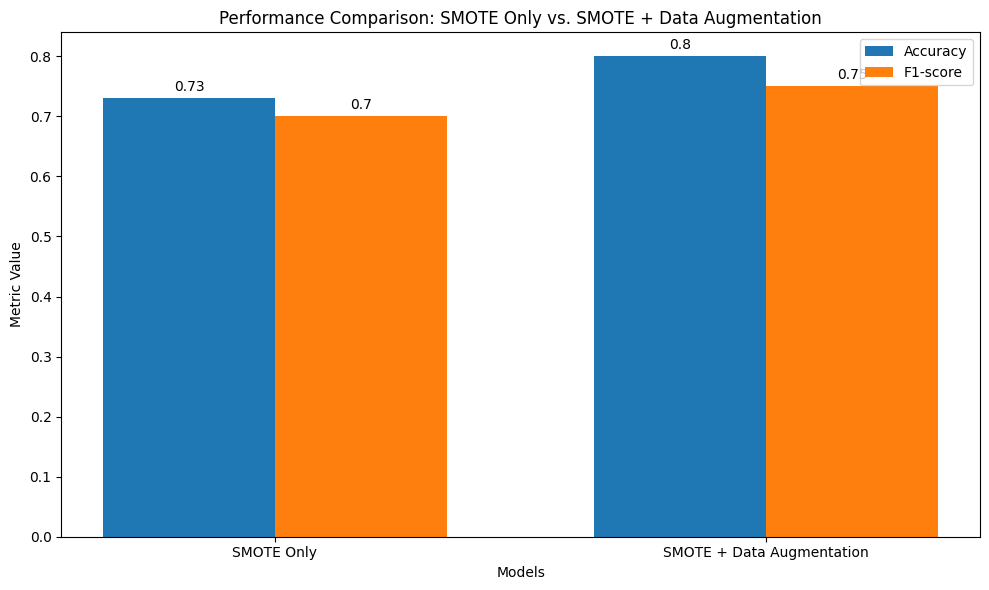

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Accuracy values
accuracy_smote_only = 0.73
accuracy_smote_data_augmentation = 0.80

# F1-score values
f1_score_smote_only = 0.70
f1_score_smote_data_augmentation = 0.75

# Create a bar plot
labels = ['SMOTE Only', 'SMOTE + Data Augmentation']
accuracy_values = [accuracy_smote_only, accuracy_smote_data_augmentation]
f1_score_values = [f1_score_smote_only, f1_score_smote_data_augmentation]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, accuracy_values, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_score_values, width, label='F1-score')

# Set plot labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Metric Value')
ax.set_title('Performance Comparison: SMOTE Only vs. SMOTE + Data Augmentation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Attach metric values on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Display the plot
plt.tight_layout()
plt.show()


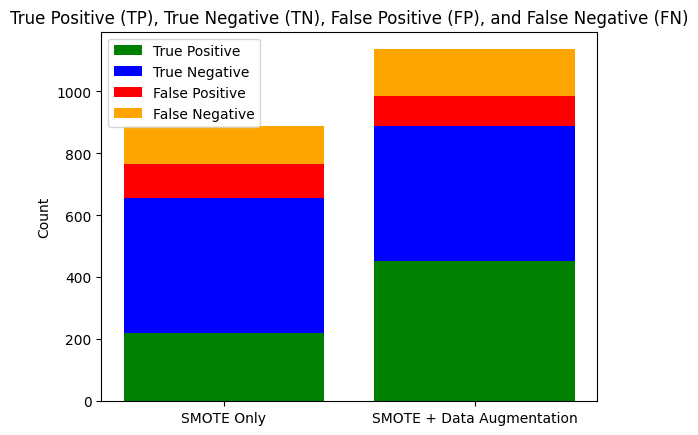

In [8]:
import matplotlib.pyplot as plt

# Define the values for TP, TN, FP, FN
tp_values = [219, 452]
tn_values = [438, 438]
fp_values = [110, 96]
fn_values = [123, 150]

# Define the labels for the models
model_labels = ['SMOTE Only', 'SMOTE + Data Augmentation']

# Set the positions of the bars on the x-axis
x_pos = range(len(model_labels))

# Plot the bars
plt.bar(x_pos, tp_values, label='True Positive', color='green')
plt.bar(x_pos, tn_values, label='True Negative', color='blue', bottom=tp_values)
plt.bar(x_pos, fp_values, label='False Positive', color='red', bottom=[tp + tn for tp, tn in zip(tp_values, tn_values)])
plt.bar(x_pos, fn_values, label='False Negative', color='orange', bottom=[tp + tn + fp for tp, tn, fp in zip(tp_values, tn_values, fp_values)])

# Set the x-axis labels
plt.xticks(x_pos, model_labels)

# Set the y-axis label
plt.ylabel('Count')

# Set the title of the chart
plt.title('True Positive (TP), True Negative (TN), False Positive (FP), and False Negative (FN)')

# Add a legend
plt.legend()

# Display the chart
plt.show()
